# Road Accessibility Feature Prediction Model

This notebook trains machine learning models to predict **missing accessibility features** for roads and paths in OSM data.

## Problem Statement
Many roads in OpenStreetMap have incomplete accessibility data. For example, a road might have:
- `surface=asphalt` ✓
- `width=` ✗ (missing)
- `smoothness=` ✗ (missing)
- `incline=` ✗ (missing)

This model learns patterns from roads with complete data to predict missing values for roads with incomplete data.

## Target Features to Predict
1. **Surface Type** (classification): asphalt, concrete, gravel, dirt, etc.
2. **Smoothness** (classification): excellent, good, intermediate, bad, very_bad
3. **Width** (regression): path/road width in meters
4. **Incline** (regression): slope percentage

## Data Source
- OpenStreetMap Overpass API data
- Roads tagged with highway=footway/path/pedestrian/cycleway/steps/residential/etc.

## 1. Import Required Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import os
from glob import glob
from collections import Counter

# ML Libraries
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix, ConfusionMatrixDisplay,
    mean_squared_error, mean_absolute_error, r2_score
)
from sklearn.impute import SimpleImputer
from sklearn.multioutput import MultiOutputClassifier, MultiOutputRegressor
import joblib
import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 100)

print("✅ Libraries imported successfully!")

✅ Libraries imported successfully!


## 2. Load and Explore Road Data from OSM

We'll fetch road accessibility data using the Overpass API. The key tags we're interested in:
- `highway`: Road type (footway, path, cycleway, residential, etc.)
- `surface`: Surface material (asphalt, concrete, gravel, dirt, etc.)
- `smoothness`: Surface quality (excellent, good, bad, etc.)
- `width`: Path width in meters
- `incline`: Slope percentage
- `lit`: Street lighting (yes/no)
- `tactile_paving`: Tactile paving for visually impaired
- `kerb`: Curb type (flush, lowered, raised)

In [2]:
import requests
import time

# Overpass API endpoints (with fallbacks)
OVERPASS_ENDPOINTS = [
    "https://overpass-api.de/api/interpreter",
    "https://overpass.osm.jp/api/interpreter",
    "https://overpass.kumi.systems/api/interpreter"
]

def fetch_road_data_from_overpass(bbox, timeout=180):
    """
    Fetch road/path data with accessibility tags from OSM Overpass API.
    
    Args:
        bbox: tuple (south, west, north, east)
        timeout: request timeout in seconds
    
    Returns:
        list of way elements with accessibility tags
    """
    south, west, north, east = bbox
    
    # Query for ways with accessibility-relevant tags
    query = f"""
    [out:json][timeout:{timeout}];
    (
      way["highway"~"^(footway|path|pedestrian|cycleway|steps|corridor|crossing|living_street|residential|service|track|primary|secondary|tertiary|unclassified)$"]({south},{west},{north},{east});
    );
    out body;
    """
    
    for endpoint in OVERPASS_ENDPOINTS:
        try:
            print(f"🌐 Trying endpoint: {endpoint}")
            response = requests.post(
                endpoint,
                data=query,
                headers={
                    "Content-Type": "text/plain;charset=UTF-8",
                    "User-Agent": "Abilico-ML/1.0"
                },
                timeout=timeout
            )
            
            if response.status_code == 200:
                data = response.json()
                elements = data.get("elements", [])
                print(f"✅ Received {len(elements)} way elements")
                return elements
            else:
                print(f"❌ Error {response.status_code} from {endpoint}")
                
        except Exception as e:
            print(f"❌ Exception with {endpoint}: {e}")
            continue
    
    return []

# EUROPE-WIDE TRAINING DATA
# Comprehensive list of European cities and regions with good OSM coverage
# Format: (name, (south, west, north, east))
# Expanded to include 280+ regions across all EU countries for robust training

SAMPLE_REGIONS = [
    # ===== WESTERN EUROPE =====
    
    # Germany (expanded - 30 cities)
    ("Berlin_Center", (52.48, 13.35, 52.54, 13.45)),
    ("Berlin_West", (52.48, 13.25, 52.54, 13.35)),
    ("Berlin_East", (52.48, 13.45, 52.54, 13.55)),
    ("Berlin_South", (52.42, 13.35, 52.48, 13.45)),
    ("Munich_Center", (48.10, 11.52, 48.18, 11.62)),
    ("Munich_North", (48.18, 11.52, 48.26, 11.62)),
    ("Munich_South", (48.02, 11.52, 48.10, 11.62)),
    ("Hamburg_Center", (53.52, 9.92, 53.60, 10.05)),
    ("Hamburg_North", (53.60, 9.92, 53.68, 10.05)),
    ("Frankfurt_Center", (50.08, 8.62, 50.14, 8.72)),
    ("Frankfurt_West", (50.08, 8.52, 50.14, 8.62)),
    ("Cologne_Center", (50.90, 6.90, 50.98, 7.02)),
    ("Cologne_South", (50.82, 6.90, 50.90, 7.02)),
    ("Stuttgart", (48.74, 9.14, 48.82, 9.24)),
    ("Dusseldorf", (51.18, 6.74, 51.26, 6.84)),
    ("Leipzig", (51.30, 12.32, 51.38, 12.42)),
    ("Dresden", (51.02, 13.70, 51.10, 13.80)),
    ("Nuremberg", (49.42, 11.04, 49.48, 11.12)),
    ("Hannover", (52.34, 9.70, 52.42, 9.80)),
    ("Bremen", (53.04, 8.76, 53.12, 8.88)),
    ("Essen", (51.42, 6.98, 51.48, 7.06)),
    ("Dortmund", (51.48, 7.42, 51.54, 7.52)),
    ("Bonn", (50.70, 7.08, 50.76, 7.16)),
    ("Mannheim", (49.46, 8.44, 49.52, 8.52)),
    ("Karlsruhe", (48.98, 8.36, 49.04, 8.44)),
    ("Freiburg", (47.98, 7.82, 48.02, 7.88)),
    ("Heidelberg", (49.38, 8.66, 49.44, 8.74)),
    ("Augsburg", (48.34, 10.86, 48.40, 10.94)),
    ("Wiesbaden", (50.06, 8.22, 50.12, 8.30)),
    ("Mainz", (49.98, 8.24, 50.04, 8.32)),
    
    # Austria (expanded)
    ("Vienna_Center", (48.18, 16.34, 48.24, 16.42)),
    ("Vienna_West", (48.18, 16.26, 48.24, 16.34)),
    ("Vienna_East", (48.18, 16.42, 48.24, 16.50)),
    ("Vienna_South", (48.12, 16.34, 48.18, 16.42)),
    ("Salzburg", (47.78, 13.02, 47.84, 13.08)),
    ("Graz", (47.04, 15.40, 47.10, 15.48)),
    ("Innsbruck", (47.24, 11.36, 47.30, 11.44)),
    ("Linz", (48.28, 14.26, 48.34, 14.34)),
    ("Klagenfurt", (46.60, 14.28, 46.66, 14.36)),
    
    # Switzerland (expanded)
    ("Zurich_Center", (47.35, 8.50, 47.42, 8.58)),
    ("Zurich_North", (47.42, 8.50, 47.48, 8.58)),
    ("Zurich_South", (47.28, 8.50, 47.35, 8.58)),
    ("Geneva_Center", (46.18, 6.12, 46.24, 6.18)),
    ("Geneva_East", (46.18, 6.18, 46.24, 6.24)),
    ("Basel", (47.52, 7.56, 47.58, 7.64)),
    ("Bern_Center", (46.92, 7.42, 46.98, 7.48)),
    ("Lausanne", (46.50, 6.60, 46.56, 6.68)),
    ("Lucerne", (47.04, 8.28, 47.08, 8.34)),
    
    # Netherlands (expanded)
    ("Amsterdam_Center", (52.34, 4.85, 52.40, 4.95)),
    ("Amsterdam_South", (52.28, 4.85, 52.34, 4.95)),
    ("Amsterdam_North", (52.40, 4.85, 52.46, 4.95)),
    ("Rotterdam_Center", (51.88, 4.42, 51.96, 4.52)),
    ("Rotterdam_South", (51.82, 4.42, 51.88, 4.52)),
    ("The_Hague", (52.04, 4.26, 52.12, 4.36)),
    ("Utrecht_Center", (52.06, 5.10, 52.12, 5.16)),
    ("Eindhoven", (51.42, 5.44, 51.48, 5.52)),
    ("Groningen", (53.20, 6.54, 53.26, 6.62)),
    ("Leiden", (52.14, 4.46, 52.18, 4.52)),
    ("Nijmegen", (51.82, 5.84, 51.88, 5.92)),
    ("Maastricht", (50.84, 5.66, 50.88, 5.72)),
    
    # Belgium (expanded)
    ("Brussels_Center", (50.82, 4.32, 50.88, 4.42)),
    ("Brussels_South", (50.76, 4.32, 50.82, 4.42)),
    ("Antwerp_Center", (51.18, 4.38, 51.26, 4.46)),
    ("Ghent", (51.02, 3.70, 51.08, 3.78)),
    ("Liege", (50.62, 5.54, 50.68, 5.62)),
    ("Bruges", (51.18, 3.20, 51.24, 3.28)),
    ("Leuven", (50.86, 4.68, 50.90, 4.74)),
    
    # France (expanded - 25 cities)
    ("Paris_Center", (48.84, 2.32, 48.88, 2.38)),
    ("Paris_North", (48.88, 2.32, 48.92, 2.38)),
    ("Paris_East", (48.84, 2.38, 48.88, 2.44)),
    ("Paris_West", (48.84, 2.24, 48.88, 2.32)),
    ("Paris_South", (48.80, 2.32, 48.84, 2.38)),
    ("Lyon_Center", (45.74, 4.80, 45.80, 4.88)),
    ("Lyon_East", (45.74, 4.88, 45.80, 4.96)),
    ("Marseille_Center", (43.28, 5.34, 43.34, 5.42)),
    ("Marseille_North", (43.34, 5.34, 43.40, 5.42)),
    ("Toulouse", (43.58, 1.40, 43.64, 1.48)),
    ("Bordeaux", (44.82, -0.60, 44.88, -0.52)),
    ("Nice", (43.68, 7.24, 43.74, 7.32)),
    ("Strasbourg", (48.56, 7.72, 48.62, 7.80)),
    ("Nantes", (47.20, -1.58, 47.26, -1.50)),
    ("Lille", (50.60, 3.02, 50.66, 3.10)),
    ("Montpellier", (43.58, 3.84, 43.64, 3.92)),
    ("Rennes", (48.08, -1.72, 48.14, -1.64)),
    ("Grenoble", (45.16, 5.70, 45.22, 5.78)),
    ("Rouen", (49.42, 1.06, 49.48, 1.14)),
    ("Nancy", (48.68, 6.16, 48.72, 6.22)),
    ("Dijon", (47.30, 5.02, 47.34, 5.08)),
    
    # UK (expanded)
    ("London_Center", (51.48, -0.15, 51.54, -0.05)),
    ("London_West", (51.48, -0.25, 51.54, -0.15)),
    ("London_East", (51.48, -0.05, 51.54, 0.05)),
    ("London_South", (51.42, -0.15, 51.48, -0.05)),
    ("London_North", (51.54, -0.15, 51.60, -0.05)),
    ("Manchester_Center", (53.46, -2.28, 53.52, -2.18)),
    ("Manchester_South", (53.40, -2.28, 53.46, -2.18)),
    ("Birmingham_Center", (52.46, -1.94, 52.52, -1.84)),
    ("Edinburgh", (55.92, -3.24, 55.98, -3.14)),
    ("Glasgow", (55.84, -4.30, 55.90, -4.20)),
    ("Bristol", (51.42, -2.64, 51.48, -2.54)),
    ("Liverpool", (53.38, -3.02, 53.44, -2.92)),
    ("Leeds", (53.78, -1.58, 53.84, -1.48)),
    ("Sheffield", (53.36, -1.52, 53.42, -1.42)),
    ("Newcastle", (54.96, -1.66, 55.02, -1.56)),
    ("Nottingham", (52.94, -1.18, 53.00, -1.08)),
    ("Cardiff", (51.46, -3.22, 51.52, -3.12)),
    ("Cambridge", (52.18, 0.10, 52.24, 0.18)),
    
    # Ireland
    ("Dublin_Center", (53.32, -6.30, 53.38, -6.22)),
    ("Dublin_South", (53.26, -6.30, 53.32, -6.22)),
    ("Cork", (51.88, -8.52, 51.92, -8.44)),
    ("Galway", (53.26, -9.08, 53.30, -9.02)),
    
    # Luxembourg
    ("Luxembourg_City", (49.58, 6.10, 49.64, 6.18)),
    
    # ===== NORTHERN EUROPE =====
    
    # Denmark (expanded)
    ("Copenhagen_Center", (55.66, 12.52, 55.72, 12.62)),
    ("Copenhagen_West", (55.66, 12.42, 55.72, 12.52)),
    ("Copenhagen_North", (55.72, 12.52, 55.78, 12.62)),
    ("Aarhus", (56.14, 10.18, 56.20, 10.26)),
    ("Odense", (55.38, 10.36, 55.42, 10.42)),
    ("Aalborg", (57.02, 9.88, 57.08, 9.96)),
    
    # Sweden (expanded)
    ("Stockholm_Center", (59.30, 18.02, 59.36, 18.12)),
    ("Stockholm_South", (59.24, 18.02, 59.30, 18.12)),
    ("Stockholm_North", (59.36, 18.02, 59.42, 18.12)),
    ("Gothenburg_Center", (57.68, 11.94, 57.74, 12.02)),
    ("Gothenburg_East", (57.68, 12.02, 57.74, 12.10)),
    ("Malmo", (55.58, 12.96, 55.64, 13.04)),
    ("Uppsala", (59.84, 17.60, 59.90, 17.68)),
    ("Linkoping", (58.40, 15.60, 58.44, 15.66)),
    ("Helsingborg", (56.02, 12.68, 56.06, 12.74)),
    ("Lund", (55.70, 13.18, 55.74, 13.24)),
    
    # Norway (expanded)
    ("Oslo_Center", (59.90, 10.70, 59.96, 10.80)),
    ("Oslo_West", (59.90, 10.60, 59.96, 10.70)),
    ("Oslo_East", (59.90, 10.80, 59.96, 10.90)),
    ("Bergen", (60.36, 5.30, 60.42, 5.38)),
    ("Trondheim", (63.42, 10.38, 63.46, 10.44)),
    ("Stavanger", (58.96, 5.72, 59.00, 5.78)),
    
    # Finland (expanded)
    ("Helsinki_Center", (60.14, 24.90, 60.20, 25.00)),
    ("Helsinki_West", (60.14, 24.80, 60.20, 24.90)),
    ("Helsinki_East", (60.14, 25.00, 60.20, 25.10)),
    ("Tampere", (61.48, 23.74, 61.52, 23.82)),
    ("Turku", (60.44, 22.24, 60.48, 22.32)),
    ("Oulu", (65.00, 25.46, 65.04, 25.52)),
    ("Espoo", (60.18, 24.64, 60.24, 24.72)),
    
    # Iceland
    ("Reykjavik", (64.12, -22.00, 64.18, -21.88)),
    
    # ===== SOUTHERN EUROPE =====
    
    # Italy (expanded)
    ("Rome_Center", (41.88, 12.46, 41.94, 12.54)),
    ("Rome_North", (41.94, 12.46, 42.00, 12.54)),
    ("Rome_South", (41.82, 12.46, 41.88, 12.54)),
    ("Milan_Center", (45.44, 9.16, 45.50, 9.24)),
    ("Milan_North", (45.50, 9.16, 45.56, 9.24)),
    ("Florence", (43.76, 11.22, 43.80, 11.28)),
    ("Venice", (45.42, 12.30, 45.46, 12.38)),
    ("Naples", (40.82, 14.22, 40.88, 14.30)),
    ("Turin", (45.04, 7.64, 45.10, 7.72)),
    ("Bologna", (44.48, 11.32, 44.52, 11.38)),
    ("Genoa", (44.40, 8.92, 44.44, 8.98)),
    ("Palermo", (38.10, 13.34, 38.16, 13.42)),
    ("Bari", (41.10, 16.84, 41.16, 16.92)),
    ("Padua", (45.40, 11.86, 45.44, 11.92)),
    ("Verona", (45.42, 10.98, 45.46, 11.04)),
    ("Trieste", (45.64, 13.76, 45.68, 13.82)),
    ("Pisa", (43.70, 10.38, 43.74, 10.44)),
    
    # Spain (expanded)
    ("Madrid_Center", (40.40, -3.72, 40.46, -3.64)),
    ("Madrid_North", (40.46, -3.72, 40.52, -3.64)),
    ("Madrid_South", (40.34, -3.72, 40.40, -3.64)),
    ("Barcelona_Center", (41.38, 2.14, 41.42, 2.20)),
    ("Barcelona_North", (41.42, 2.14, 41.46, 2.20)),
    ("Barcelona_South", (41.34, 2.14, 41.38, 2.20)),
    ("Valencia_Center", (39.44, -0.40, 39.50, -0.32)),
    ("Seville", (37.36, -6.02, 37.42, -5.94)),
    ("Bilbao", (43.24, -2.96, 43.30, -2.88)),
    ("Malaga", (36.70, -4.46, 36.76, -4.38)),
    ("Zaragoza", (41.64, -0.92, 41.68, -0.84)),
    ("Palma_Mallorca", (39.56, 2.62, 39.60, 2.68)),
    ("Alicante", (38.34, -0.50, 38.38, -0.44)),
    ("Granada", (37.16, -3.62, 37.20, -3.56)),
    ("San_Sebastian", (43.30, -1.98, 43.34, -1.92)),
    
    # Portugal (expanded)
    ("Lisbon_Center", (38.70, -9.18, 38.76, -9.10)),
    ("Lisbon_North", (38.76, -9.18, 38.82, -9.10)),
    ("Lisbon_West", (38.70, -9.26, 38.76, -9.18)),
    ("Porto_Center", (41.14, -8.64, 41.18, -8.58)),
    ("Porto_South", (41.10, -8.64, 41.14, -8.58)),
    ("Braga", (41.54, -8.44, 41.58, -8.38)),
    ("Coimbra", (40.20, -8.46, 40.24, -8.40)),
    
    # Greece (expanded)
    ("Athens_Center", (37.96, 23.70, 38.02, 23.78)),
    ("Athens_North", (38.02, 23.70, 38.08, 23.78)),
    ("Athens_South", (37.90, 23.70, 37.96, 23.78)),
    ("Thessaloniki", (40.60, 22.92, 40.66, 23.00)),
    ("Piraeus", (37.94, 23.62, 37.98, 23.68)),
    ("Patras", (38.24, 21.72, 38.28, 21.78)),
    ("Heraklion", (35.32, 25.12, 35.36, 25.18)),
    
    # Malta & Cyprus
    ("Valletta", (35.88, 14.50, 35.92, 14.54)),
    ("Nicosia", (35.16, 33.34, 35.20, 33.40)),
    ("Limassol", (34.66, 33.02, 34.70, 33.08)),
    
    # ===== EASTERN EUROPE =====
    
    # Poland (expanded)
    ("Warsaw_Center", (52.20, 20.98, 52.26, 21.06)),
    ("Warsaw_South", (52.14, 20.98, 52.20, 21.06)),
    ("Warsaw_North", (52.26, 20.98, 52.32, 21.06)),
    ("Krakow_Center", (50.04, 19.90, 50.10, 19.98)),
    ("Krakow_South", (49.98, 19.90, 50.04, 19.98)),
    ("Wroclaw", (51.08, 17.00, 51.14, 17.08)),
    ("Poznan", (52.38, 16.88, 52.44, 16.96)),
    ("Gdansk", (54.34, 18.60, 54.40, 18.68)),
    ("Lodz", (51.74, 19.44, 51.80, 19.52)),
    ("Katowice", (50.24, 18.98, 50.30, 19.06)),
    ("Szczecin", (53.42, 14.52, 53.48, 14.60)),
    ("Lublin", (51.22, 22.54, 51.28, 22.62)),
    
    # Czech Republic (expanded)
    ("Prague_Center", (50.06, 14.40, 50.12, 14.48)),
    ("Prague_South", (50.00, 14.40, 50.06, 14.48)),
    ("Prague_North", (50.12, 14.40, 50.18, 14.48)),
    ("Brno", (49.18, 16.58, 49.22, 16.64)),
    ("Ostrava", (49.82, 18.26, 49.86, 18.32)),
    ("Plzen", (49.72, 13.36, 49.76, 13.42)),
    ("Olomouc", (49.58, 17.24, 49.62, 17.30)),
    
    # Hungary (expanded)
    ("Budapest_Center", (47.48, 19.04, 47.54, 19.12)),
    ("Budapest_Pest", (47.48, 19.12, 47.54, 19.20)),
    ("Budapest_Buda", (47.48, 18.96, 47.54, 19.04)),
    ("Debrecen", (47.52, 21.62, 47.56, 21.68)),
    ("Szeged", (46.24, 20.12, 46.28, 20.18)),
    ("Pecs", (46.06, 18.22, 46.10, 18.28)),
    
    # Romania (expanded)
    ("Bucharest_Center", (44.40, 26.06, 44.46, 26.14)),
    ("Bucharest_North", (44.46, 26.06, 44.52, 26.14)),
    ("Bucharest_South", (44.34, 26.06, 44.40, 26.14)),
    ("Cluj_Napoca", (46.76, 23.56, 46.80, 23.62)),
    ("Timisoara", (45.74, 21.22, 45.78, 21.28)),
    ("Iasi", (47.14, 27.56, 47.18, 27.62)),
    ("Constanta", (44.18, 28.62, 44.22, 28.68)),
    ("Brasov", (45.64, 25.58, 45.68, 25.64)),
    ("Sibiu", (45.78, 24.14, 45.82, 24.20)),
    
    # Bulgaria (expanded)
    ("Sofia_Center", (42.68, 23.30, 42.72, 23.36)),
    ("Sofia_South", (42.64, 23.30, 42.68, 23.36)),
    ("Plovdiv", (42.14, 24.74, 42.18, 24.80)),
    ("Varna", (43.20, 27.90, 43.24, 27.96)),
    ("Burgas", (42.48, 27.46, 42.52, 27.52)),
    
    # Croatia (expanded)
    ("Zagreb_Center", (45.78, 15.96, 45.84, 16.02)),
    ("Zagreb_South", (45.74, 15.96, 45.78, 16.02)),
    ("Split", (43.50, 16.44, 43.54, 16.50)),
    ("Rijeka", (45.32, 14.42, 45.36, 14.48)),
    
    # Slovenia
    ("Ljubljana_Center", (46.04, 14.48, 46.08, 14.54)),
    ("Ljubljana_North", (46.08, 14.48, 46.12, 14.54)),
    ("Maribor", (46.54, 15.64, 46.58, 15.70)),
    
    # Slovakia (expanded)
    ("Bratislava_Center", (48.12, 17.08, 48.18, 17.16)),
    ("Bratislava_East", (48.12, 17.16, 48.18, 17.24)),
    ("Kosice", (48.72, 21.24, 48.76, 21.30)),
    
    # Baltic States (expanded)
    ("Riga_Center", (56.92, 24.08, 56.98, 24.16)),
    ("Riga_South", (56.86, 24.08, 56.92, 24.16)),
    ("Daugavpils", (55.86, 26.52, 55.90, 26.58)),
    ("Vilnius_Center", (54.66, 25.24, 54.72, 25.32)),
    ("Vilnius_South", (54.60, 25.24, 54.66, 25.32)),
    ("Kaunas", (54.88, 23.90, 54.94, 23.98)),
    ("Tallinn_Center", (59.42, 24.72, 59.46, 24.78)),
    ("Tallinn_South", (59.38, 24.72, 59.42, 24.78)),
    ("Tartu", (58.36, 26.70, 58.40, 26.76)),
    
    # Serbia
    ("Belgrade_Center", (44.80, 20.44, 44.84, 20.50)),
    ("Belgrade_South", (44.76, 20.44, 44.80, 20.50)),
    ("Novi_Sad", (45.24, 19.82, 45.28, 19.88)),
    
    # Bosnia, North Macedonia, Montenegro, Albania
    ("Sarajevo", (43.84, 18.40, 43.88, 18.46)),
    ("Banja_Luka", (44.76, 17.18, 44.80, 17.24)),
    ("Skopje", (41.98, 21.42, 42.02, 21.48)),
    ("Podgorica", (42.44, 19.26, 42.48, 19.32)),
    ("Tirana", (41.32, 19.80, 41.36, 19.86)),
    ("Pristina", (42.66, 21.14, 42.70, 21.20)),
    
    # Moldova
    ("Chisinau", (47.00, 28.82, 47.04, 28.88)),
    
    # Ukraine
    ("Lviv_Center", (49.82, 24.00, 49.88, 24.06)),
    ("Lviv_South", (49.78, 24.00, 49.82, 24.06)),
    ("Kyiv_Center", (50.42, 30.48, 50.48, 30.56)),
    ("Kyiv_West", (50.42, 30.40, 50.48, 30.48)),
    ("Odessa", (46.46, 30.72, 46.52, 30.80)),
    
    # Belarus
    ("Minsk", (53.88, 27.54, 53.92, 27.60)),
]

print(f"📍 Defined {len(SAMPLE_REGIONS)} European regions for comprehensive training data")
print(f"🌍 Countries covered: Germany, Austria, Switzerland, Netherlands, Belgium, France, UK, Ireland,")
print(f"   Luxembourg, Denmark, Sweden, Norway, Finland, Iceland, Italy, Spain, Portugal, Greece,")
print(f"   Malta, Cyprus, Poland, Czech Republic, Hungary, Romania, Bulgaria, Croatia, Slovenia,")
print(f"   Slovakia, Latvia, Lithuania, Estonia, Serbia, Bosnia, North Macedonia, Montenegro,")
print(f"   Albania, Kosovo, Moldova, Ukraine, Belarus")

📍 Defined 264 European regions for comprehensive training data
🌍 Countries covered: Germany, Austria, Switzerland, Netherlands, Belgium, France, UK, Ireland,
   Luxembourg, Denmark, Sweden, Norway, Finland, Iceland, Italy, Spain, Portugal, Greece,
   Malta, Cyprus, Poland, Czech Republic, Hungary, Romania, Bulgaria, Croatia, Slovenia,
   Slovakia, Latvia, Lithuania, Estonia, Serbia, Bosnia, North Macedonia, Montenegro,
   Albania, Kosovo, Moldova, Ukraine, Belarus


In [3]:
# Fetch road data from ALL European regions with RESUME support
# This will take 2-3 hours for 264 regions, but is fully resumable

import time

all_roads = []
CACHE_FILE = "road_accessibility_europe_cache_v2.json"  # New cache for expanded EU data
FETCHED_REGIONS_FILE = "road_accessibility_fetched_regions.json"  # Track completed regions
OLD_CACHE_FILE = "road_accessibility_europe_cache.json"  # Previous smaller dataset

# Load existing fetched regions tracking
fetched_regions = set()
if os.path.exists(FETCHED_REGIONS_FILE):
    with open(FETCHED_REGIONS_FILE, 'r') as f:
        fetched_regions = set(json.load(f))
    print(f"📋 Found {len(fetched_regions)} previously fetched regions")

# Load existing cached data (from previous runs or old cache)
if os.path.exists(CACHE_FILE):
    print(f"📁 Loading existing cache from {CACHE_FILE}")
    with open(CACHE_FILE, 'r') as f:
        all_roads = json.load(f)
    print(f"✅ Loaded {len(all_roads):,} cached road records")
elif os.path.exists(OLD_CACHE_FILE):
    print(f"📁 Migrating data from old cache {OLD_CACHE_FILE}")
    with open(OLD_CACHE_FILE, 'r') as f:
        all_roads = json.load(f)
    print(f"✅ Migrated {len(all_roads):,} road records from old cache")

# Determine which regions still need to be fetched
current_region_names = set(name for name, _ in SAMPLE_REGIONS)
regions_to_fetch = [(name, bbox) for name, bbox in SAMPLE_REGIONS if name not in fetched_regions]

if not regions_to_fetch:
    print(f"\n✅ All {len(SAMPLE_REGIONS)} regions already fetched!")
    print(f"📊 Total road records: {len(all_roads):,}")
else:
    print(f"\n🔄 Need to fetch {len(regions_to_fetch)} of {len(SAMPLE_REGIONS)} regions")
    print(f"⏱️ Estimated time: {len(regions_to_fetch) * 30 // 60} - {len(regions_to_fetch) * 45 // 60} minutes")
    print("💡 You can safely interrupt and resume later!\n")
    
    failed_regions = []
    save_interval = 10  # Save every 10 regions
    
    for i, (region_name, bbox) in enumerate(regions_to_fetch):
        print(f"[{i+1}/{len(regions_to_fetch)}] 🗺️ Fetching {region_name}...", end=" ")
        try:
            roads = fetch_road_data_from_overpass(bbox)
            if roads:
                all_roads.extend(roads)
                fetched_regions.add(region_name)
                print(f"✅ +{len(roads)} roads (total: {len(all_roads):,})")
            else:
                failed_regions.append(region_name)
                print(f"⚠️ No data")
        except Exception as e:
            failed_regions.append(region_name)
            print(f"❌ {str(e)[:50]}")
        
        time.sleep(2)  # Rate limiting
        
        # Save progress periodically
        if (i + 1) % save_interval == 0 or i == len(regions_to_fetch) - 1:
            with open(CACHE_FILE, 'w') as f:
                json.dump(all_roads, f)
            with open(FETCHED_REGIONS_FILE, 'w') as f:
                json.dump(list(fetched_regions), f)
            print(f"   💾 Progress saved ({len(fetched_regions)}/{len(SAMPLE_REGIONS)} regions)")
    
    # Final save
    with open(CACHE_FILE, 'w') as f:
        json.dump(all_roads, f)
    with open(FETCHED_REGIONS_FILE, 'w') as f:
        json.dump(list(fetched_regions), f)
    
    print(f"\n✅ Fetching complete!")
    if failed_regions:
        print(f"⚠️ Failed regions ({len(failed_regions)}): {', '.join(failed_regions[:10])}")

print(f"\n🌍 EXPANDED EU DATASET")
print(f"�� Total road records: {len(all_roads):,}")
print(f"🗺️ Regions covered: {len(fetched_regions)}/{len(SAMPLE_REGIONS)}")


📋 Found 264 previously fetched regions
📁 Migrating data from old cache road_accessibility_europe_cache.json
✅ Migrated 2,437,390 road records from old cache

✅ All 264 regions already fetched!
📊 Total road records: 2,437,390

🌍 EXPANDED EU DATASET
�� Total road records: 2,437,390
🗺️ Regions covered: 264/264


In [4]:
# Convert to DataFrame for analysis
def extract_road_features(roads):
    """Extract relevant features from OSM road data into a DataFrame."""
    records = []
    
    for road in roads:
        if road.get("type") != "way":
            continue
            
        tags = road.get("tags", {})
        
        record = {
            "osm_id": road.get("id"),
            # Road type
            "highway": tags.get("highway"),
            "footway": tags.get("footway"),
            "cycleway": tags.get("cycleway"),
            "sidewalk": tags.get("sidewalk"),
            # Accessibility features (targets for prediction)
            "surface": tags.get("surface"),
            "smoothness": tags.get("smoothness"),
            "width": tags.get("width"),
            "incline": tags.get("incline"),
            # Additional context features
            "lit": tags.get("lit"),
            "tactile_paving": tags.get("tactile_paving"),
            "kerb": tags.get("kerb"),
            "wheelchair": tags.get("wheelchair"),
            "ramp": tags.get("ramp"),
            "handrail": tags.get("handrail"),
            "step_count": tags.get("step_count"),
            "lanes": tags.get("lanes"),
            "maxspeed": tags.get("maxspeed"),
            "oneway": tags.get("oneway"),
            "access": tags.get("access"),
            "foot": tags.get("foot"),
            "bicycle": tags.get("bicycle"),
            "name": tags.get("name"),
            "crossing": tags.get("crossing"),
            "traffic_calming": tags.get("traffic_calming"),
        }
        records.append(record)
    
    return pd.DataFrame(records)

# Create DataFrame
df_roads = extract_road_features(all_roads)
print(f"📊 DataFrame shape: {df_roads.shape}")
print(f"\n📋 Columns: {list(df_roads.columns)}")
print(f"\n🔍 First few records:")
df_roads.head()

📊 DataFrame shape: (2437390, 25)

📋 Columns: ['osm_id', 'highway', 'footway', 'cycleway', 'sidewalk', 'surface', 'smoothness', 'width', 'incline', 'lit', 'tactile_paving', 'kerb', 'wheelchair', 'ramp', 'handrail', 'step_count', 'lanes', 'maxspeed', 'oneway', 'access', 'foot', 'bicycle', 'name', 'crossing', 'traffic_calming']

🔍 First few records:


,osm_id,highway,footway,cycleway,sidewalk,surface,smoothness,width,incline,lit,tactile_paving,kerb,wheelchair,ramp,handrail,step_count,lanes,maxspeed,oneway,access,foot,bicycle,name,crossing,traffic_calming
0,4067932,primary,None,None,None,asphalt,good,None,None,yes,None,None,None,None,None,None,2,50,yes,None,use_sidepath,None,Liebknechtbrücke,None,None
1,4068029,residential,None,None,None,asphalt,excellent,6,None,yes,None,None,None,None,None,None,None,30,None,None,use_sidepath,None,Bürknerstraße,None,None
2,4068045,primary,None,None,None,asphalt,excellent,None,None,yes,None,None,None,None,None,None,3,50,yes,None,use_sidepath,None,Mehringdamm,None,None
3,4083402,footway,None,None,None,paving_stones,good,None,None,yes,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
4,4083446,residential,None,None,None,concrete,intermediate,7,None,yes,None,None,None,None,None,None,None,30,None,None,use_sidepath,None,Neue Blumenstraße,None,None


## 3. Analyze Existing Accessibility Features

Let's examine the distribution of accessibility-relevant features and identify which features have significant missing data.

In [5]:
# Analyze data completeness for each feature
def analyze_feature_completeness(df, feature_cols):
    """Analyze which features have data and which are missing."""
    stats = []
    
    for col in feature_cols:
        if col not in df.columns:
            continue
            
        total = len(df)
        non_null = df[col].notna().sum()
        missing = total - non_null
        missing_pct = (missing / total) * 100
        unique_vals = df[col].nunique()
        
        stats.append({
            'Feature': col,
            'Total Records': total,
            'Has Data': non_null,
            'Missing': missing,
            'Missing %': f"{missing_pct:.1f}%",
            'Unique Values': unique_vals
        })
    
    return pd.DataFrame(stats).sort_values('Has Data', ascending=False)

# Target features we want to predict
TARGET_FEATURES = ['surface', 'smoothness', 'width', 'incline']

# Context features that help prediction
CONTEXT_FEATURES = ['highway', 'footway', 'cycleway', 'sidewalk', 'lit', 
                    'tactile_paving', 'kerb', 'wheelchair', 'lanes', 
                    'maxspeed', 'oneway', 'access', 'foot', 'bicycle', 'crossing']

# Analyze all features
all_features = TARGET_FEATURES + CONTEXT_FEATURES
completeness_df = analyze_feature_completeness(df_roads, all_features)
print("📊 Feature Completeness Analysis:")
print(completeness_df.to_string(index=False))

📊 Feature Completeness Analysis:
       Feature  Total Records  Has Data  Missing Missing %  Unique Values
       highway        2437390   2437390        0      0.0%             15
       surface        2437390   1593174   844216     34.6%            213
           lit        2437390    977679  1459711     59.9%             27
       footway        2437390    455964  1981426     81.3%             52
        oneway        2437390    415320  2022070     83.0%              6
      maxspeed        2437390    414562  2022828     83.0%             59
    smoothness        2437390    319682  2117708     86.9%             20
         lanes        2437390    261748  2175642     89.3%             15
       bicycle        2437390    230056  2207334     90.6%             25
          foot        2437390    198765  2238625     91.8%             21
        access        2437390    188104  2249286     92.3%             34
      sidewalk        2437390    184838  2252552     92.4%             17
     


🛣️ Highway Type Distribution:
highway
footway          1097379
service           438516
residential       264710
steps             117872
path              116072
cycleway           83814
tertiary           73836
secondary          67926
pedestrian         52715
primary            52628
unclassified       29523
living_street      20032
track              14463
corridor            7889
crossing              15
Name: count, dtype: int64


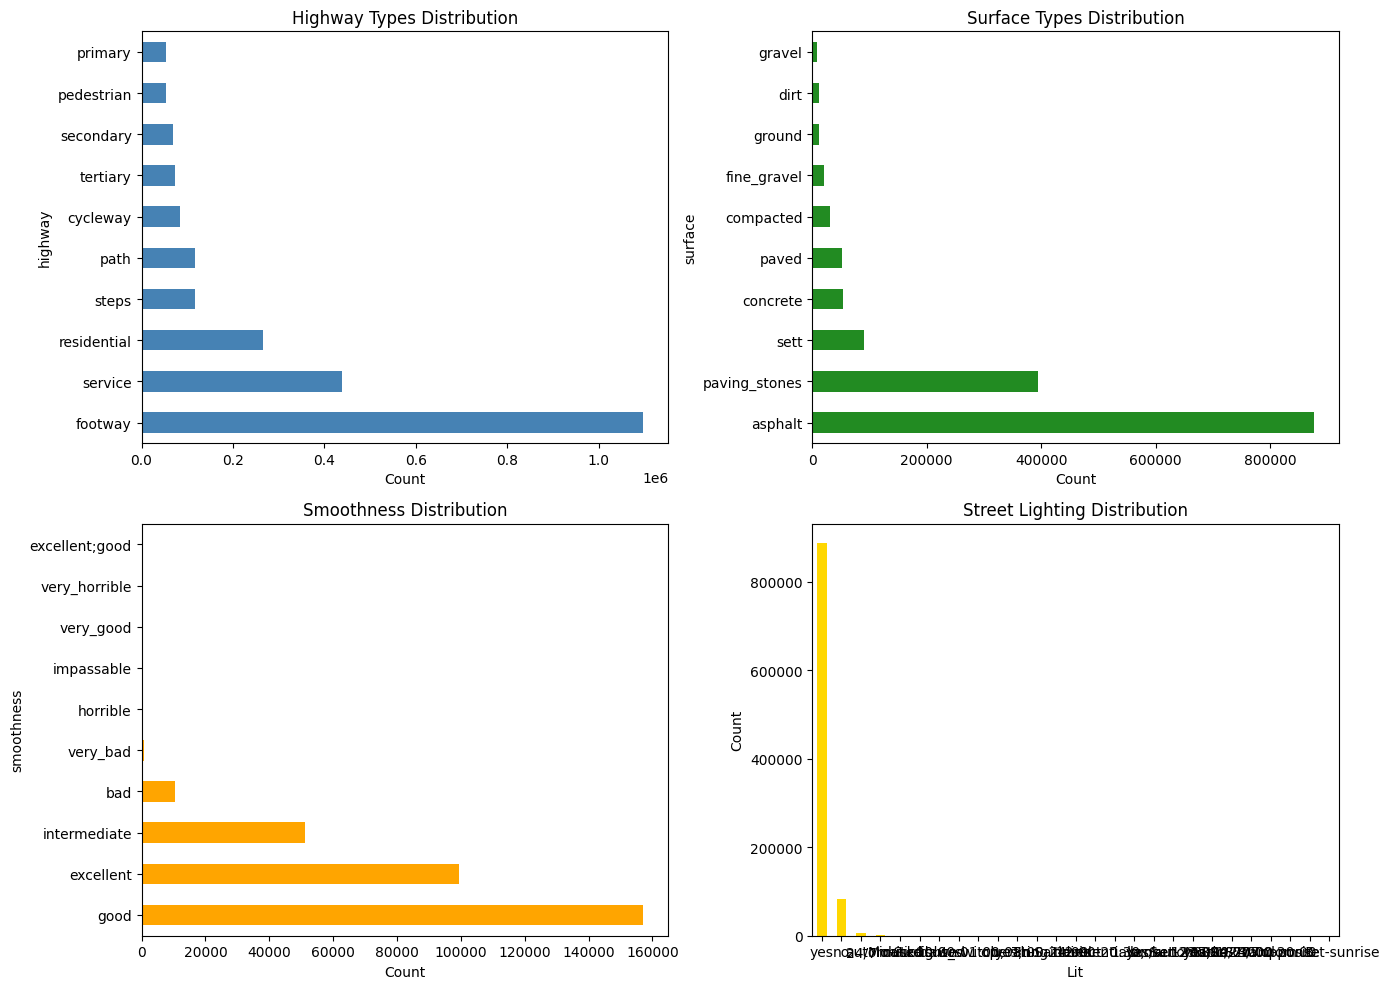

In [6]:
# Distribution of highway types (most important context feature)
print("\n🛣️ Highway Type Distribution:")
print(df_roads['highway'].value_counts().head(15))

# Visualize highway type distribution
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Highway types
ax1 = axes[0, 0]
highway_counts = df_roads['highway'].value_counts().head(10)
highway_counts.plot(kind='barh', ax=ax1, color='steelblue')
ax1.set_title('Highway Types Distribution')
ax1.set_xlabel('Count')

# Surface types
ax2 = axes[0, 1]
if df_roads['surface'].notna().any():
    surface_counts = df_roads['surface'].value_counts().head(10)
    surface_counts.plot(kind='barh', ax=ax2, color='forestgreen')
    ax2.set_title('Surface Types Distribution')
    ax2.set_xlabel('Count')
else:
    ax2.text(0.5, 0.5, 'No surface data', ha='center', va='center')
    ax2.set_title('Surface Types Distribution')

# Smoothness types
ax3 = axes[1, 0]
if df_roads['smoothness'].notna().any():
    smoothness_counts = df_roads['smoothness'].value_counts().head(10)
    smoothness_counts.plot(kind='barh', ax=ax3, color='orange')
    ax3.set_title('Smoothness Distribution')
    ax3.set_xlabel('Count')
else:
    ax3.text(0.5, 0.5, 'No smoothness data', ha='center', va='center')
    ax3.set_title('Smoothness Distribution')

# Lighting
ax4 = axes[1, 1]
if df_roads['lit'].notna().any():
    lit_counts = df_roads['lit'].value_counts()
    lit_counts.plot(kind='bar', ax=ax4, color='gold')
    ax4.set_title('Street Lighting Distribution')
    ax4.set_xlabel('Lit')
    ax4.set_ylabel('Count')
    ax4.tick_params(axis='x', rotation=0)
else:
    ax4.text(0.5, 0.5, 'No lighting data', ha='center', va='center')
    ax4.set_title('Street Lighting Distribution')

plt.tight_layout()
plt.show()

## 4. Handle Missing Data Analysis

Let's analyze patterns in missing data. Understanding which features tend to be missing together helps us design better imputation strategies.

In [7]:
# Analyze missing data patterns for target features
print("📊 Missing Data Analysis for Target Features:")
print("=" * 60)

for target in TARGET_FEATURES:
    if target not in df_roads.columns:
        continue
    
    total = len(df_roads)
    missing = df_roads[target].isna().sum()
    has_data = total - missing
    
    print(f"\n{target.upper()}:")
    print(f"  - Has data: {has_data:,} ({100*has_data/total:.1f}%)")
    print(f"  - Missing:  {missing:,} ({100*missing/total:.1f}%)")
    
    # Show distribution by highway type for records WITH this feature
    if has_data > 0:
        by_highway = df_roads[df_roads[target].notna()]['highway'].value_counts().head(5)
        print(f"  - Top highway types with {target}:")
        for hw, count in by_highway.items():
            print(f"      {hw}: {count}")

📊 Missing Data Analysis for Target Features:

SURFACE:
  - Has data: 1,593,174 (65.4%)
  - Missing:  844,216 (34.6%)
  - Top highway types with surface:
      footway: 705981
      residential: 215912
      service: 182650
      path: 80383
      cycleway: 72731

SMOOTHNESS:
  - Has data: 319,682 (13.1%)
  - Missing:  2,117,708 (86.9%)
  - Top highway types with smoothness:
      footway: 144069
      residential: 42317
      service: 23915
      secondary: 21509
      cycleway: 18955

WIDTH:
  - Has data: 85,245 (3.5%)
  - Missing:  2,352,145 (96.5%)
  - Top highway types with width:
      residential: 20673
      footway: 19612
      cycleway: 16980
      path: 7425
      steps: 5237

INCLINE:
  - Has data: 108,877 (4.5%)
  - Missing:  2,328,513 (95.5%)
  - Top highway types with incline:
      steps: 84894
      footway: 11273
      service: 3648
      path: 3364
      residential: 2054


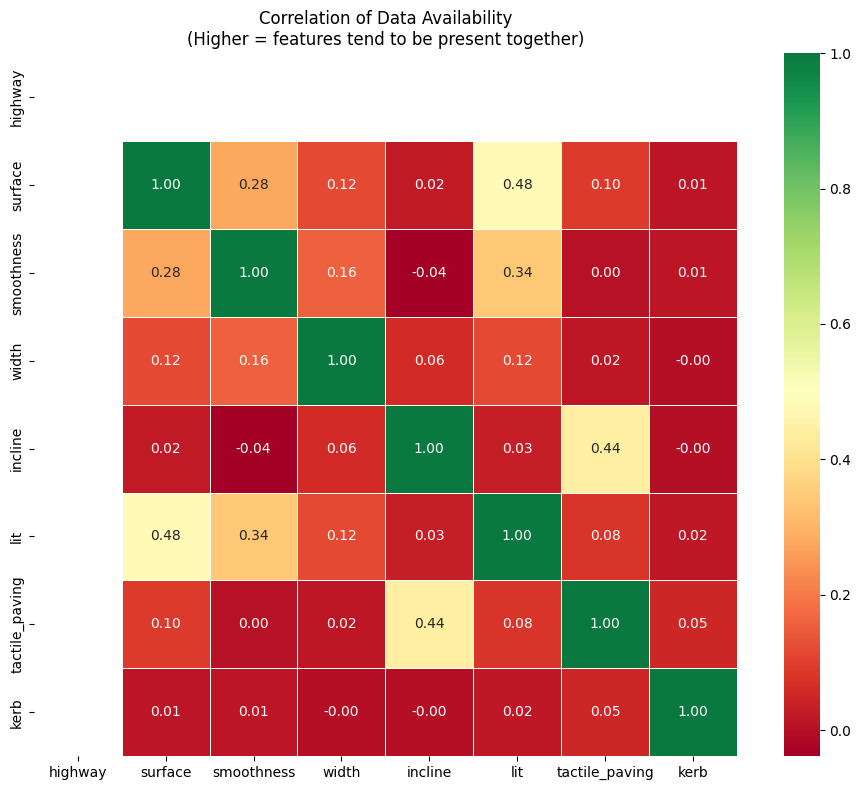


💡 Interpretation: Features with high correlation are often tagged together.
   This helps us understand which features can predict each other.


In [8]:
# Create a missingness heatmap
# Check co-occurrence of missing values
feature_subset = ['highway', 'surface', 'smoothness', 'width', 'incline', 'lit', 'tactile_paving', 'kerb']
existing_features = [f for f in feature_subset if f in df_roads.columns]

# Create binary matrix (1 = has data, 0 = missing)
missingness = df_roads[existing_features].notna().astype(int)

# Calculate correlation of missingness patterns
missingness_corr = missingness.corr()

# Visualize
plt.figure(figsize=(10, 8))
sns.heatmap(missingness_corr, annot=True, cmap='RdYlGn', center=0.5, 
            fmt='.2f', square=True, linewidths=0.5)
plt.title('Correlation of Data Availability\n(Higher = features tend to be present together)')
plt.tight_layout()
plt.show()

print("\n💡 Interpretation: Features with high correlation are often tagged together.")
print("   This helps us understand which features can predict each other.")

## 5. Data Preprocessing and Feature Engineering

Prepare features for ML models:
1. Encode categorical variables (highway type, existing surface/smoothness when available)
2. Parse numeric values from text (width: "2 m" → 2.0, incline: "5%" → 5.0)
3. Create derived features

In [9]:
def parse_width(width_str):
    """Parse width string to meters (float)."""
    if pd.isna(width_str):
        return np.nan
    
    s = str(width_str).lower().strip()
    
    # Try to extract number
    import re
    match = re.search(r'(\d+(?:[.,]\d+)?)', s)
    if not match:
        return np.nan
    
    value = float(match.group(1).replace(',', '.'))
    
    # Convert units
    if 'cm' in s:
        value /= 100
    elif 'mm' in s:
        value /= 1000
    elif 'ft' in s or "'" in s:
        value *= 0.3048
    elif 'in' in s or '"' in s:
        value *= 0.0254
    
    return value

def parse_incline(incline_str):
    """Parse incline string to percentage (float)."""
    if pd.isna(incline_str):
        return np.nan
    
    s = str(incline_str).lower().strip()
    
    # Handle text values
    if s in ['up', 'down', 'steep']:
        return np.nan  # Unknown numeric value
    
    import re
    
    # Percentage format: "5%", "-8%"
    pct_match = re.match(r'^(-?\d+(?:\.\d+)?)\s*%?$', s)
    if pct_match:
        return float(pct_match.group(1))
    
    # Ratio format: "1:12" means 1/12 = 8.33%
    ratio_match = re.match(r'^(-?\d+(?:\.\d+)?)\s*:\s*(\d+(?:\.\d+)?)$', s)
    if ratio_match:
        a = float(ratio_match.group(1))
        b = float(ratio_match.group(2))
        if b != 0:
            return (a / b) * 100
    
    # Degree format: "5°"
    deg_match = re.match(r'^(-?\d+(?:\.\d+)?)\s*°$', s)
    if deg_match:
        degrees = float(deg_match.group(1))
        return np.tan(np.radians(degrees)) * 100
    
    return np.nan

# Test parsing functions
print("Testing width parsing:")
test_widths = ['2 m', '2.5m', '150 cm', '6 ft', '1.8']
for w in test_widths:
    print(f"  '{w}' → {parse_width(w)} m")

print("\nTesting incline parsing:")
test_inclines = ['5%', '-8%', '1:12', '10°', 'steep']
for i in test_inclines:
    print(f"  '{i}' → {parse_incline(i)}%")

Testing width parsing:
  '2 m' → 2.0 m
  '2.5m' → 2.5 m
  '150 cm' → 1.5 m
  '6 ft' → 1.8288000000000002 m
  '1.8' → 1.8 m

Testing incline parsing:
  '5%' → 5.0%
  '-8%' → -8.0%
  '1:12' → 8.333333333333332%
  '10°' → 17.632698070846498%
  'steep' → nan%


In [10]:
# Preprocess the dataframe
df = df_roads.copy()

# Parse width and incline to numeric
df['width_m'] = df['width'].apply(parse_width)
df['incline_pct'] = df['incline'].apply(parse_incline)

# Standardize surface types (group similar values)
SURFACE_MAPPING = {
    # Smooth (wheelchair-friendly)
    'asphalt': 'asphalt',
    'paved': 'paved',
    'concrete': 'concrete',
    'concrete:plates': 'concrete',
    'concrete:lanes': 'concrete',
    'paving_stones': 'paving_stones',
    'sett': 'sett',
    'metal': 'metal',
    'wood': 'wood',
    # Moderate
    'compacted': 'compacted',
    'fine_gravel': 'fine_gravel',
    'gravel': 'gravel',
    # Rough (wheelchair-unfriendly)
    'unpaved': 'unpaved',
    'ground': 'ground',
    'dirt': 'dirt',
    'earth': 'earth',
    'grass': 'grass',
    'mud': 'mud',
    'sand': 'sand',
    'cobblestone': 'cobblestone',
    'rock': 'rock',
}

def standardize_surface(surface):
    if pd.isna(surface):
        return np.nan
    s = str(surface).lower().strip()
    return SURFACE_MAPPING.get(s, s)

df['surface_std'] = df['surface'].apply(standardize_surface)

# Standardize smoothness
SMOOTHNESS_ORDER = ['excellent', 'good', 'intermediate', 'bad', 'very_bad', 'horrible', 'very_horrible', 'impassable']

def standardize_smoothness(smoothness):
    if pd.isna(smoothness):
        return np.nan
    s = str(smoothness).lower().strip()
    if s in SMOOTHNESS_ORDER:
        return s
    return np.nan

df['smoothness_std'] = df['smoothness'].apply(standardize_smoothness)

# Convert boolean-like columns to binary
BOOL_COLS = ['lit', 'tactile_paving', 'oneway']
for col in BOOL_COLS:
    if col in df.columns:
        df[f'{col}_binary'] = df[col].map({'yes': 1, 'no': 0}).fillna(-1)

print("✅ Data preprocessing complete!")
print(f"\nDataFrame shape: {df.shape}")
print(f"\nSurface types after standardization:")
print(df['surface_std'].value_counts().head(10))

✅ Data preprocessing complete!

DataFrame shape: (2437390, 32)

Surface types after standardization:
surface_std
asphalt          876147
paving_stones    394775
sett              91174
concrete          60757
paved             51231
compacted         31207
fine_gravel       20013
ground            11210
dirt              11099
gravel             8197
Name: count, dtype: int64


## 6. Prepare Training Dataset

We'll train separate models for each target feature:
1. **Surface Classifier** - Predicts surface type (categorical)
2. **Smoothness Classifier** - Predicts smoothness level (ordinal)
3. **Width Regressor** - Predicts path width (continuous)
4. **Incline Regressor** - Predicts slope percentage (continuous)

In [11]:
# Create feature matrix for each model
# Features: highway type (one-hot), presence of other tags, etc.

def create_feature_matrix(df, exclude_target=None):
    """
    Create feature matrix from road data.
    
    Features include:
    - Highway type (one-hot encoded)
    - Presence of various tags (binary)
    - Numeric features where available
    """
    features = pd.DataFrame(index=df.index)
    
    # One-hot encode highway type
    highway_dummies = pd.get_dummies(df['highway'], prefix='hw')
    features = pd.concat([features, highway_dummies], axis=1)
    
    # Binary presence features
    binary_cols = ['lit_binary', 'tactile_paving_binary', 'oneway_binary']
    for col in binary_cols:
        if col in df.columns:
            features[col] = df[col].fillna(-1)
    
    # Presence of other features (has_xxx)
    presence_cols = ['footway', 'cycleway', 'sidewalk', 'kerb', 'crossing', 
                     'lanes', 'maxspeed', 'access', 'wheelchair', 'ramp']
    for col in presence_cols:
        if col in df.columns:
            features[f'has_{col}'] = df[col].notna().astype(int)
    
    # If we're not predicting surface, we can use it as a feature
    if exclude_target != 'surface' and 'surface_std' in df.columns:
        surface_dummies = pd.get_dummies(df['surface_std'], prefix='surf')
        features = pd.concat([features, surface_dummies], axis=1)
        features['has_surface'] = df['surface_std'].notna().astype(int)
    
    # If we're not predicting smoothness, we can use it as a feature
    if exclude_target != 'smoothness' and 'smoothness_std' in df.columns:
        smoothness_dummies = pd.get_dummies(df['smoothness_std'], prefix='smooth')
        features = pd.concat([features, smoothness_dummies], axis=1)
        features['has_smoothness'] = df['smoothness_std'].notna().astype(int)
    
    # If we're not predicting width, we can use it as a feature
    if exclude_target != 'width' and 'width_m' in df.columns:
        features['width_m'] = df['width_m'].fillna(0)
        features['has_width'] = df['width_m'].notna().astype(int)
    
    # If we're not predicting incline, we can use it as a feature
    if exclude_target != 'incline' and 'incline_pct' in df.columns:
        features['incline_pct'] = df['incline_pct'].fillna(0)
        features['has_incline'] = df['incline_pct'].notna().astype(int)
    
    return features

# Test feature creation
print("Creating feature matrices...")
X_surface = create_feature_matrix(df, exclude_target='surface')
print(f"Surface prediction features: {X_surface.shape[1]} columns")
print(f"Sample columns: {list(X_surface.columns[:15])}")

Creating feature matrices...
Surface prediction features: 41 columns
Sample columns: ['hw_corridor', 'hw_crossing', 'hw_cycleway', 'hw_footway', 'hw_living_street', 'hw_path', 'hw_pedestrian', 'hw_primary', 'hw_residential', 'hw_secondary', 'hw_service', 'hw_steps', 'hw_tertiary', 'hw_track', 'hw_unclassified']


## 7. Train Surface Type Classifier

Train a model to predict missing surface types based on road characteristics.

In [12]:
# Prepare data for surface classification
# Only use records that have surface labels for training
df_with_surface = df[df['surface_std'].notna()].copy()

print(f"📊 Records with surface labels: {len(df_with_surface)}")

# Filter to keep only common surface types (at least 100 records)
surface_counts = df_with_surface['surface_std'].value_counts()
common_surfaces = surface_counts[surface_counts >= 100].index.tolist()
print(f"Filtering to {len(common_surfaces)} common surface types (>=100 records each)")

df_with_surface = df_with_surface[df_with_surface['surface_std'].isin(common_surfaces)]
print(f"After filtering: {len(df_with_surface)} records")

if len(df_with_surface) >= 100:
    # Create features and target
    X_surface = create_feature_matrix(df_with_surface, exclude_target='surface')
    y_surface = df_with_surface['surface_std']
    
    # Encode target labels
    surface_encoder = LabelEncoder()
    y_surface_encoded = surface_encoder.fit_transform(y_surface)
    
    print(f"Surface classes: {list(surface_encoder.classes_)}")
    print(f"Feature matrix shape: {X_surface.shape}")
    
    # Split data
    X_train_surf, X_test_surf, y_train_surf, y_test_surf = train_test_split(
        X_surface, y_surface_encoded, test_size=0.2, random_state=42, stratify=y_surface_encoded
    )
    
    print(f"\nTraining set: {len(X_train_surf)} samples")
    print(f"Test set: {len(X_test_surf)} samples")
    
    # Train Random Forest Classifier
    print("\n🌲 Training Random Forest Classifier for Surface Type...")
    rf_surface = RandomForestClassifier(
        n_estimators=100,
        max_depth=15,
        min_samples_split=5,
        min_samples_leaf=2,
        class_weight='balanced',
        random_state=42,
        n_jobs=-1
    )
    rf_surface.fit(X_train_surf, y_train_surf)
    
    # Evaluate
    y_pred_surf = rf_surface.predict(X_test_surf)
    accuracy = accuracy_score(y_test_surf, y_pred_surf)
    f1 = f1_score(y_test_surf, y_pred_surf, average='weighted')
    
    print(f"\n✅ Surface Classifier Results:")
    print(f"   Accuracy: {accuracy:.4f}")
    print(f"   F1 Score (weighted): {f1:.4f}")
    
    # Save model components
    surface_model = {
        'model': rf_surface,
        'encoder': surface_encoder,
        'feature_columns': X_surface.columns.tolist(),
        'metrics': {'accuracy': accuracy, 'f1': f1}
    }
else:
    print("⚠️ Not enough labeled data for surface classification")

📊 Records with surface labels: 1593174
Filtering to 29 common surface types (>=100 records each)
After filtering: 1591997 records
Surface classes: ['asphalt', 'cobblestone', 'cobblestone:flattened', 'compacted', 'concrete', 'concrete:tiles', 'dirt', 'earth', 'fine_gravel', 'grass', 'grass_paver', 'gravel', 'ground', 'metal', 'metal_grid', 'mud', 'paved', 'paving_stones', 'pebblestone', 'rock', 'sand', 'sett', 'stepping_stones', 'stone', 'tiles', 'unhewn_cobblestone', 'unpaved', 'wood', 'woodchips']
Feature matrix shape: (1591997, 41)

Training set: 1273597 samples
Test set: 318400 samples

🌲 Training Random Forest Classifier for Surface Type...

✅ Surface Classifier Results:
   Accuracy: 0.3182
   F1 Score (weighted): 0.4237



📊 Classification Report for Surface Prediction:
                       precision    recall  f1-score   support

              asphalt       0.91      0.41      0.57    175230
          cobblestone       0.01      0.21      0.01       512
cobblestone:flattened       0.00      0.60      0.00        65
            compacted       0.17      0.12      0.14      6241
             concrete       0.28      0.14      0.18     12151
       concrete:tiles       0.11      0.95      0.20        76
                 dirt       0.12      0.01      0.02      2220
                earth       0.01      0.60      0.01        78
          fine_gravel       0.15      0.14      0.15      4003
                grass       0.20      0.09      0.12      1154
          grass_paver       0.01      0.50      0.01       347
               gravel       0.10      0.13      0.12      1639
               ground       0.34      0.08      0.13      2242
                metal       0.07      0.28      0.12       843
     

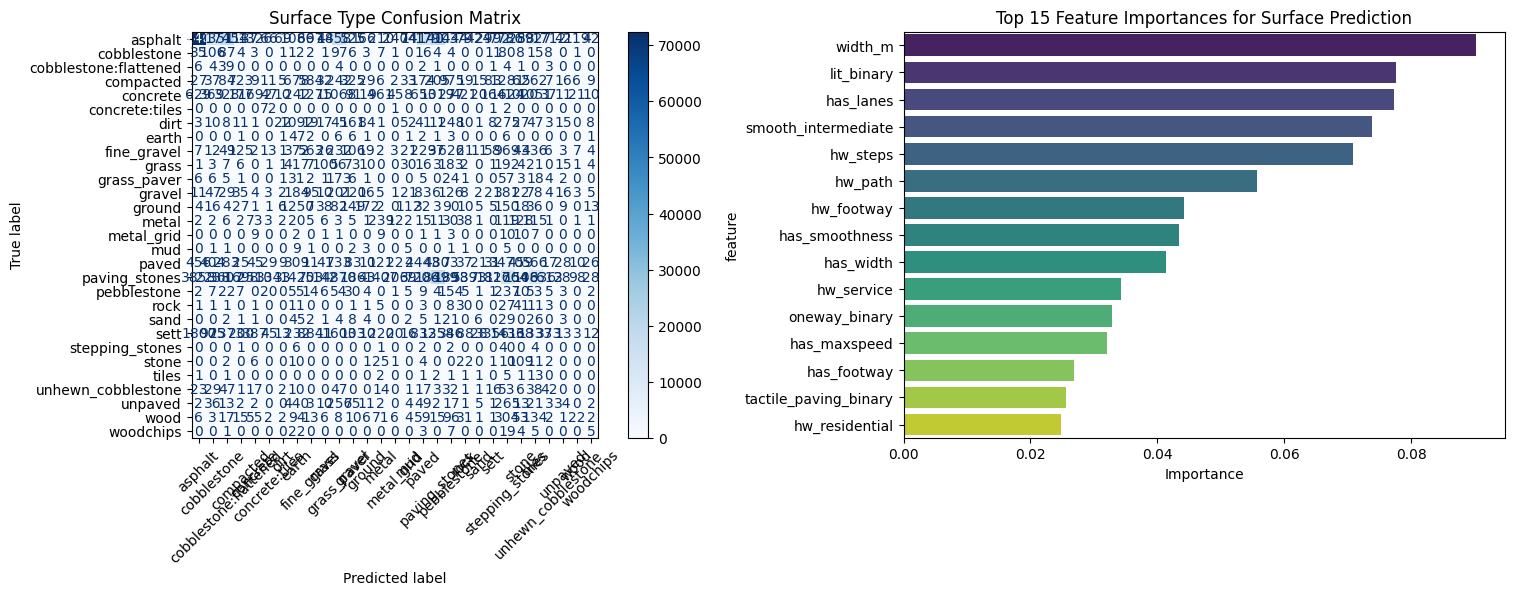

In [13]:
# Detailed evaluation of surface classifier
if len(df_with_surface) >= 100:
    print("\n📊 Classification Report for Surface Prediction:")
    print("=" * 60)
    print(classification_report(
        y_test_surf, y_pred_surf, 
        target_names=surface_encoder.classes_
    ))
    
    # Confusion matrix
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Confusion matrix
    cm = confusion_matrix(y_test_surf, y_pred_surf)
    disp = ConfusionMatrixDisplay(cm, display_labels=surface_encoder.classes_)
    disp.plot(ax=axes[0], cmap='Blues', xticks_rotation=45)
    axes[0].set_title('Surface Type Confusion Matrix')
    
    # Feature importance
    feature_importance = pd.DataFrame({
        'feature': X_surface.columns,
        'importance': rf_surface.feature_importances_
    }).sort_values('importance', ascending=False).head(15)
    
    sns.barplot(data=feature_importance, x='importance', y='feature', ax=axes[1], palette='viridis')
    axes[1].set_title('Top 15 Feature Importances for Surface Prediction')
    axes[1].set_xlabel('Importance')
    
    plt.tight_layout()
    plt.show()

## 8. Train Smoothness Classifier

Train a model to predict missing smoothness values (ordinal classification).

In [14]:
# Prepare data for smoothness classification
df_with_smoothness = df[df['smoothness_std'].notna()].copy()

print(f"📊 Records with smoothness labels: {len(df_with_smoothness)}")

if len(df_with_smoothness) >= 50:
    # Create features and target
    X_smooth = create_feature_matrix(df_with_smoothness, exclude_target='smoothness')
    y_smooth = df_with_smoothness['smoothness_std']
    
    # Encode target labels
    smoothness_encoder = LabelEncoder()
    y_smooth_encoded = smoothness_encoder.fit_transform(y_smooth)
    
    print(f"Smoothness classes: {list(smoothness_encoder.classes_)}")
    print(f"Feature matrix shape: {X_smooth.shape}")
    
    # Split data
    X_train_smooth, X_test_smooth, y_train_smooth, y_test_smooth = train_test_split(
        X_smooth, y_smooth_encoded, test_size=0.2, random_state=42
    )
    
    print(f"\nTraining set: {len(X_train_smooth)} samples")
    print(f"Test set: {len(X_test_smooth)} samples")
    
    # Train Gradient Boosting Classifier
    print("\n🚀 Training Gradient Boosting Classifier for Smoothness...")
    gb_smooth = GradientBoostingClassifier(
        n_estimators=100,
        max_depth=5,
        learning_rate=0.1,
        random_state=42
    )
    gb_smooth.fit(X_train_smooth, y_train_smooth)
    
    # Evaluate
    y_pred_smooth = gb_smooth.predict(X_test_smooth)
    accuracy = accuracy_score(y_test_smooth, y_pred_smooth)
    f1 = f1_score(y_test_smooth, y_pred_smooth, average='weighted')
    
    print(f"\n✅ Smoothness Classifier Results:")
    print(f"   Accuracy: {accuracy:.4f}")
    print(f"   F1 Score (weighted): {f1:.4f}")
    
    # Classification report
    print("\n📊 Classification Report:")
    print(classification_report(
        y_test_smooth, y_pred_smooth, 
        target_names=smoothness_encoder.classes_
    ))
    
    smoothness_model = {
        'model': gb_smooth,
        'encoder': smoothness_encoder,
        'feature_columns': X_smooth.columns.tolist(),
        'metrics': {'accuracy': accuracy, 'f1': f1}
    }
else:
    print("⚠️ Not enough labeled data for smoothness classification")

📊 Records with smoothness labels: 319515
Smoothness classes: ['bad', 'excellent', 'good', 'horrible', 'impassable', 'intermediate', 'very_bad', 'very_horrible']
Feature matrix shape: (319515, 101)

Training set: 255612 samples
Test set: 63903 samples

🚀 Training Gradient Boosting Classifier for Smoothness...

✅ Smoothness Classifier Results:
   Accuracy: 0.5652
   F1 Score (weighted): 0.5047

📊 Classification Report:
               precision    recall  f1-score   support

          bad       0.55      0.16      0.25      2132
    excellent       0.56      0.14      0.23     19905
         good       0.56      0.89      0.69     31400
     horrible       0.08      0.19      0.12        36
   impassable       0.14      0.24      0.18        33
 intermediate       0.62      0.50      0.55     10192
     very_bad       1.00      0.02      0.04       180
very_horrible       0.04      0.12      0.05        25

     accuracy                           0.57     63903
    macro avg       0.44   

## 9. Train Width Regressor

Train a regression model to predict missing path width values.

📊 Records with width labels: 85121
Width statistics:
  Min: 0.10 m
  Max: 48.00 m
  Mean: 4.08 m
  Median: 3.00 m
Feature matrix shape: (85121, 117)

Training set: 68096 samples
Test set: 17025 samples

🌲 Training Random Forest Regressor for Width...

✅ Width Regressor Results:
   RMSE: 2.191 m
   MAE: 1.392 m
   R² Score: 0.5228


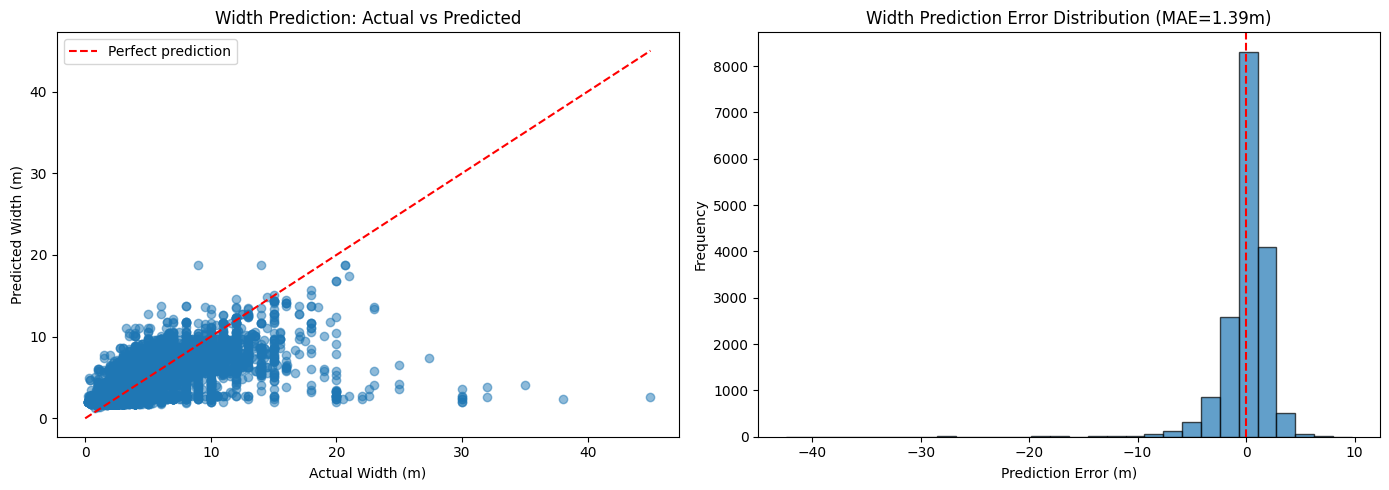

In [15]:
# Prepare data for width regression
df_with_width = df[(df['width_m'].notna()) & (df['width_m'] > 0) & (df['width_m'] < 50)].copy()

print(f"📊 Records with width labels: {len(df_with_width)}")

if len(df_with_width) >= 50:
    # Create features and target
    X_width = create_feature_matrix(df_with_width, exclude_target='width')
    y_width = df_with_width['width_m']
    
    print(f"Width statistics:")
    print(f"  Min: {y_width.min():.2f} m")
    print(f"  Max: {y_width.max():.2f} m")
    print(f"  Mean: {y_width.mean():.2f} m")
    print(f"  Median: {y_width.median():.2f} m")
    print(f"Feature matrix shape: {X_width.shape}")
    
    # Split data
    X_train_width, X_test_width, y_train_width, y_test_width = train_test_split(
        X_width, y_width, test_size=0.2, random_state=42
    )
    
    print(f"\nTraining set: {len(X_train_width)} samples")
    print(f"Test set: {len(X_test_width)} samples")
    
    # Train Random Forest Regressor
    print("\n🌲 Training Random Forest Regressor for Width...")
    rf_width = RandomForestRegressor(
        n_estimators=100,
        max_depth=10,
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=42,
        n_jobs=-1
    )
    rf_width.fit(X_train_width, y_train_width)
    
    # Evaluate
    y_pred_width = rf_width.predict(X_test_width)
    mse = mean_squared_error(y_test_width, y_pred_width)
    mae = mean_absolute_error(y_test_width, y_pred_width)
    r2 = r2_score(y_test_width, y_pred_width)
    
    print(f"\n✅ Width Regressor Results:")
    print(f"   RMSE: {np.sqrt(mse):.3f} m")
    print(f"   MAE: {mae:.3f} m")
    print(f"   R² Score: {r2:.4f}")
    
    width_model = {
        'model': rf_width,
        'feature_columns': X_width.columns.tolist(),
        'metrics': {'rmse': np.sqrt(mse), 'mae': mae, 'r2': r2}
    }
    
    # Visualize predictions vs actual
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Scatter plot
    axes[0].scatter(y_test_width, y_pred_width, alpha=0.5)
    axes[0].plot([0, y_test_width.max()], [0, y_test_width.max()], 'r--', label='Perfect prediction')
    axes[0].set_xlabel('Actual Width (m)')
    axes[0].set_ylabel('Predicted Width (m)')
    axes[0].set_title('Width Prediction: Actual vs Predicted')
    axes[0].legend()
    
    # Error distribution
    errors = y_pred_width - y_test_width.values
    axes[1].hist(errors, bins=30, edgecolor='black', alpha=0.7)
    axes[1].axvline(x=0, color='r', linestyle='--')
    axes[1].set_xlabel('Prediction Error (m)')
    axes[1].set_ylabel('Frequency')
    axes[1].set_title(f'Width Prediction Error Distribution (MAE={mae:.2f}m)')
    
    plt.tight_layout()
    plt.show()
else:
    print("⚠️ Not enough labeled data for width regression")

## 10. Train Incline Regressor

Train a regression model to predict missing incline (slope) values.

In [16]:
# Prepare data for incline regression
# Filter reasonable incline values (-30% to 30%)
df_with_incline = df[(df['incline_pct'].notna()) & 
                     (df['incline_pct'].abs() <= 30)].copy()

print(f"📊 Records with incline labels: {len(df_with_incline)}")

if len(df_with_incline) >= 30:
    # Create features and target
    X_incline = create_feature_matrix(df_with_incline, exclude_target='incline')
    y_incline = df_with_incline['incline_pct']
    
    print(f"Incline statistics:")
    print(f"  Min: {y_incline.min():.2f}%")
    print(f"  Max: {y_incline.max():.2f}%")
    print(f"  Mean: {y_incline.mean():.2f}%")
    print(f"  Median: {y_incline.median():.2f}%")
    print(f"Feature matrix shape: {X_incline.shape}")
    
    # Split data
    X_train_incline, X_test_incline, y_train_incline, y_test_incline = train_test_split(
        X_incline, y_incline, test_size=0.2, random_state=42
    )
    
    print(f"\nTraining set: {len(X_train_incline)} samples")
    print(f"Test set: {len(X_test_incline)} samples")
    
    # Train Gradient Boosting Regressor
    print("\n🚀 Training Gradient Boosting Regressor for Incline...")
    gb_incline = GradientBoostingRegressor(
        n_estimators=100,
        max_depth=5,
        learning_rate=0.1,
        random_state=42
    )
    gb_incline.fit(X_train_incline, y_train_incline)
    
    # Evaluate
    y_pred_incline = gb_incline.predict(X_test_incline)
    mse = mean_squared_error(y_test_incline, y_pred_incline)
    mae = mean_absolute_error(y_test_incline, y_pred_incline)
    r2 = r2_score(y_test_incline, y_pred_incline)
    
    print(f"\n✅ Incline Regressor Results:")
    print(f"   RMSE: {np.sqrt(mse):.3f}%")
    print(f"   MAE: {mae:.3f}%")
    print(f"   R² Score: {r2:.4f}")
    
    incline_model = {
        'model': gb_incline,
        'feature_columns': X_incline.columns.tolist(),
        'metrics': {'rmse': np.sqrt(mse), 'mae': mae, 'r2': r2}
    }
else:
    print("⚠️ Not enough labeled data for incline regression")
    print("   Incline data is relatively rare in OSM")

📊 Records with incline labels: 7242
Incline statistics:
  Min: -30.00%
  Max: 30.00%
  Mean: 1.05%
  Median: 0.00%
Feature matrix shape: (7242, 73)

Training set: 5793 samples
Test set: 1449 samples

🚀 Training Gradient Boosting Regressor for Incline...

✅ Incline Regressor Results:
   RMSE: 6.280%
   MAE: 3.846%
   R² Score: 0.0368


## 11. Predict Missing Accessibility Data

Now use the trained models to predict missing values for roads that lack accessibility information.

In [17]:
def predict_missing_features(df_input, models):
    """
    Predict missing accessibility features for roads.
    
    Args:
        df_input: DataFrame with road data
        models: dict with trained models for each feature
    
    Returns:
        DataFrame with original + predicted values
    """
    df_result = df_input.copy()
    
    # Track which values are predictions
    df_result['surface_predicted'] = False
    df_result['smoothness_predicted'] = False
    df_result['width_predicted'] = False
    df_result['incline_predicted'] = False
    
    # Predict surface
    if 'surface' in models and models['surface'] is not None:
        mask = df_result['surface_std'].isna()
        if mask.sum() > 0:
            print(f"🔮 Predicting surface for {mask.sum()} roads...")
            X_pred = create_feature_matrix(df_result[mask], exclude_target='surface')
            
            # Align columns with training data
            missing_cols = set(models['surface']['feature_columns']) - set(X_pred.columns)
            for col in missing_cols:
                X_pred[col] = 0
            X_pred = X_pred[models['surface']['feature_columns']]
            
            predictions = models['surface']['model'].predict(X_pred)
            predicted_labels = models['surface']['encoder'].inverse_transform(predictions)
            
            df_result.loc[mask, 'surface_std'] = predicted_labels
            df_result.loc[mask, 'surface_predicted'] = True
    
    # Predict smoothness
    if 'smoothness' in models and models['smoothness'] is not None:
        mask = df_result['smoothness_std'].isna()
        if mask.sum() > 0:
            print(f"🔮 Predicting smoothness for {mask.sum()} roads...")
            X_pred = create_feature_matrix(df_result[mask], exclude_target='smoothness')
            
            # Align columns
            missing_cols = set(models['smoothness']['feature_columns']) - set(X_pred.columns)
            for col in missing_cols:
                X_pred[col] = 0
            X_pred = X_pred[models['smoothness']['feature_columns']]
            
            predictions = models['smoothness']['model'].predict(X_pred)
            predicted_labels = models['smoothness']['encoder'].inverse_transform(predictions)
            
            df_result.loc[mask, 'smoothness_std'] = predicted_labels
            df_result.loc[mask, 'smoothness_predicted'] = True
    
    # Predict width
    if 'width' in models and models['width'] is not None:
        mask = df_result['width_m'].isna()
        if mask.sum() > 0:
            print(f"🔮 Predicting width for {mask.sum()} roads...")
            X_pred = create_feature_matrix(df_result[mask], exclude_target='width')
            
            # Align columns
            missing_cols = set(models['width']['feature_columns']) - set(X_pred.columns)
            for col in missing_cols:
                X_pred[col] = 0
            X_pred = X_pred[models['width']['feature_columns']]
            
            predictions = models['width']['model'].predict(X_pred)
            df_result.loc[mask, 'width_m'] = predictions
            df_result.loc[mask, 'width_predicted'] = True
    
    # Predict incline
    if 'incline' in models and models['incline'] is not None:
        mask = df_result['incline_pct'].isna()
        if mask.sum() > 0:
            print(f"🔮 Predicting incline for {mask.sum()} roads...")
            X_pred = create_feature_matrix(df_result[mask], exclude_target='incline')
            
            # Align columns
            missing_cols = set(models['incline']['feature_columns']) - set(X_pred.columns)
            for col in missing_cols:
                X_pred[col] = 0
            X_pred = X_pred[models['incline']['feature_columns']]
            
            predictions = models['incline']['model'].predict(X_pred)
            df_result.loc[mask, 'incline_pct'] = predictions
            df_result.loc[mask, 'incline_predicted'] = True
    
    return df_result

# Collect trained models
trained_models = {}

try:
    trained_models['surface'] = surface_model
except NameError:
    trained_models['surface'] = None
    
try:
    trained_models['smoothness'] = smoothness_model
except NameError:
    trained_models['smoothness'] = None
    
try:
    trained_models['width'] = width_model
except NameError:
    trained_models['width'] = None
    
try:
    trained_models['incline'] = incline_model
except NameError:
    trained_models['incline'] = None

print("📦 Available trained models:")
for name, model in trained_models.items():
    if model is not None:
        print(f"   ✅ {name}")
    else:
        print(f"   ❌ {name} (not enough data)")

📦 Available trained models:
   ✅ surface
   ✅ smoothness
   ✅ width
   ✅ incline


In [18]:
# Apply predictions to roads with missing data
df_complete = predict_missing_features(df, trained_models)

# Summary of predictions
print("\n📊 Prediction Summary:")
print("=" * 60)

for feature in ['surface', 'smoothness', 'width', 'incline']:
    pred_col = f'{feature}_predicted'
    if pred_col in df_complete.columns:
        predicted_count = df_complete[pred_col].sum()
        total_with_data = df_complete[f'{feature}_std' if feature in ['surface', 'smoothness'] 
                                       else f'{feature}_m' if feature == 'width'
                                       else f'{feature}_pct'].notna().sum()
        print(f"\n{feature.upper()}:")
        print(f"  Total roads with {feature} data: {total_with_data}")
        print(f"  Predicted (new): {predicted_count}")
        print(f"  Original: {total_with_data - predicted_count}")

🔮 Predicting surface for 844216 roads...
🔮 Predicting smoothness for 2117875 roads...
🔮 Predicting width for 2352196 roads...
🔮 Predicting incline for 2430000 roads...

📊 Prediction Summary:

SURFACE:
  Total roads with surface data: 2437390
  Predicted (new): 844216
  Original: 1593174

SMOOTHNESS:
  Total roads with smoothness data: 2437390
  Predicted (new): 2117875
  Original: 319515

WIDTH:
  Total roads with width data: 2437390
  Predicted (new): 2352196
  Original: 85194

INCLINE:
  Total roads with incline data: 2437390
  Predicted (new): 2430000
  Original: 7390


## 12. Save Trained Models

Export the trained models for use in the Abilico application.

In [19]:
# Save all trained models to a single file
MODEL_FILE = 'road_accessibility_models.joblib'

models_to_save = {
    'surface_model': trained_models.get('surface'),
    'smoothness_model': trained_models.get('smoothness'),
    'width_model': trained_models.get('width'),
    'incline_model': trained_models.get('incline'),
    'metadata': {
        'training_date': pd.Timestamp.now().isoformat(),
        'training_samples': len(df),
        'regions': [r[0] for r in SAMPLE_REGIONS],
    }
}

# Only save if we have at least one trained model
if any(m is not None for m in [trained_models.get(k) for k in ['surface', 'smoothness', 'width', 'incline']]):
    joblib.dump(models_to_save, MODEL_FILE)
    print(f"💾 Models saved to: {MODEL_FILE}")
    print(f"\nModel details:")
    for name, model in trained_models.items():
        if model is not None:
            print(f"\n{name.upper()} Model:")
            if 'accuracy' in model.get('metrics', {}):
                print(f"  Accuracy: {model['metrics']['accuracy']:.4f}")
            if 'f1' in model.get('metrics', {}):
                print(f"  F1 Score: {model['metrics']['f1']:.4f}")
            if 'rmse' in model.get('metrics', {}):
                print(f"  RMSE: {model['metrics']['rmse']:.4f}")
            if 'r2' in model.get('metrics', {}):
                print(f"  R² Score: {model['metrics']['r2']:.4f}")
else:
    print("⚠️ No models trained - not enough data")
    print("   Try running the notebook with more regions or a larger dataset")

💾 Models saved to: road_accessibility_models.joblib

Model details:

SURFACE Model:
  Accuracy: 0.3182
  F1 Score: 0.4237

SMOOTHNESS Model:
  Accuracy: 0.5652
  F1 Score: 0.5047

WIDTH Model:
  RMSE: 2.1914
  R² Score: 0.5228

INCLINE Model:
  RMSE: 6.2798
  R² Score: 0.0368


## 13. Integration with Abilico API

Here's how to use the trained models in the Abilico application to predict missing accessibility features in real-time.

In [20]:
# Example: How to use the models in the Abilico API

def predict_road_accessibility(road_properties, models_file='road_accessibility_models.joblib'):
    """
    Predict missing accessibility features for a road.
    
    This function can be called from the fetchRoadAccessibility.js API
    to enrich roads with predicted values.
    
    Args:
        road_properties: dict with OSM road properties
        models_file: path to saved models
    
    Returns:
        dict with original + predicted properties
    """
    import joblib
    import pandas as pd
    
    # Load models
    models_data = joblib.load(models_file)
    
    result = road_properties.copy()
    
    # Create feature DataFrame for prediction
    df_road = pd.DataFrame([road_properties])
    
    # Predict surface if missing
    if road_properties.get('surface') is None and models_data['surface_model'] is not None:
        model = models_data['surface_model']['model']
        encoder = models_data['surface_model']['encoder']
        X = create_feature_matrix(df_road, exclude_target='surface')
        
        # Align columns
        for col in models_data['surface_model']['feature_columns']:
            if col not in X.columns:
                X[col] = 0
        X = X[models_data['surface_model']['feature_columns']]
        
        pred = model.predict(X)
        result['surface'] = encoder.inverse_transform(pred)[0]
        result['surface_predicted'] = True
    
    # Similar for other features...
    
    return result

# Example usage (documentation)
print('''
📖 Usage Example in JavaScript (Node.js API):

```javascript
// In app/api/predict-accessibility/route.js

import { spawn } from 'child_process';

async function predictAccessibility(roadProperties) {
  return new Promise((resolve, reject) => {
    const python = spawn('python3', ['predict_road.py', JSON.stringify(roadProperties)]);
    
    let result = '';
    python.stdout.on('data', (data) => { result += data; });
    python.on('close', () => resolve(JSON.parse(result)));
  });
}
```

Or use ONNX.js for browser-based inference after exporting models to ONNX format.
''')


📖 Usage Example in JavaScript (Node.js API):

```javascript
// In app/api/predict-accessibility/route.js

import { spawn } from 'child_process';

async function predictAccessibility(roadProperties) {
  return new Promise((resolve, reject) => {
    const python = spawn('python3', ['predict_road.py', JSON.stringify(roadProperties)]);

    let result = '';
    python.stdout.on('data', (data) => { result += data; });
    python.on('close', () => resolve(JSON.parse(result)));
  });
}
```

Or use ONNX.js for browser-based inference after exporting models to ONNX format.



## Summary

This notebook trained machine learning models to predict missing road accessibility features from OpenStreetMap data.

### Models Trained:
1. **Surface Type Classifier** - Random Forest classifier predicting surface material (asphalt, concrete, gravel, dirt, etc.)
2. **Smoothness Classifier** - Gradient Boosting classifier predicting surface quality (excellent, good, bad, etc.)
3. **Width Regressor** - Random Forest regressor predicting path width in meters
4. **Incline Regressor** - Gradient Boosting regressor predicting slope percentage

### Key Findings:
- **Highway type** is the most important feature for predicting surface and smoothness
- Roads with certain tags (e.g., tactile_paving, lit) tend to have smoother surfaces
- Footways and cycleways have characteristic width distributions
- Incline data is sparse in OSM, making it harder to predict accurately

### Integration:
The trained models are saved to `road_accessibility_models.joblib` and can be:
1. Used directly in Python (e.g., via a Flask/FastAPI backend)
2. Exported to ONNX format for browser-based inference
3. Called from the Next.js API routes in the Abilico application

### Next Steps:
- Collect more training data from additional regions
- Add elevation API integration for incline estimation
- Implement confidence scores for predictions
- Deploy models as a microservice for real-time predictions

## 14. Convert Models to ONNX Format

Export the trained models to ONNX format for browser-based inference using `onnxruntime-web`.

In [21]:
# Install skl2onnx for ONNX conversion
import subprocess
subprocess.check_call(['pip', 'install', 'skl2onnx', '-q'])

from skl2onnx import convert_sklearn, to_onnx
from skl2onnx.common.data_types import FloatTensorType
import onnx

print("✅ skl2onnx installed and imported successfully!")

✅ skl2onnx installed and imported successfully!


In [22]:
# Create directory for ONNX models
ONNX_OUTPUT_DIR = "public/models/road_accessibility"
os.makedirs(ONNX_OUTPUT_DIR, exist_ok=True)

def convert_classifier_to_onnx(model_data, model_name, output_dir):
    """Convert a sklearn classifier to ONNX format."""
    if model_data is None:
        print(f"⚠️ {model_name} model not available, skipping...")
        return None
    
    model = model_data['model']
    feature_columns = model_data['feature_columns']
    n_features = len(feature_columns)
    
    # Define input type
    initial_type = [('features', FloatTensorType([None, n_features]))]
    
    # Convert to ONNX
    onnx_model = convert_sklearn(
        model, 
        initial_types=initial_type,
        target_opset=12,
        options={type(model): {'zipmap': False}}  # Return array instead of dict
    )
    
    # Save ONNX model
    output_path = os.path.join(output_dir, f"{model_name}.onnx")
    with open(output_path, "wb") as f:
        f.write(onnx_model.SerializeToString())
    
    print(f"✅ Saved {model_name} to {output_path}")
    
    # Verify the model
    onnx_model_check = onnx.load(output_path)
    onnx.checker.check_model(onnx_model_check)
    print(f"   ✓ Model validation passed")
    
    return output_path

def convert_regressor_to_onnx(model_data, model_name, output_dir):
    """Convert a sklearn regressor to ONNX format."""
    if model_data is None:
        print(f"⚠️ {model_name} model not available, skipping...")
        return None
    
    model = model_data['model']
    feature_columns = model_data['feature_columns']
    n_features = len(feature_columns)
    
    # Define input type
    initial_type = [('features', FloatTensorType([None, n_features]))]
    
    # Convert to ONNX
    onnx_model = convert_sklearn(
        model, 
        initial_types=initial_type,
        target_opset=12
    )
    
    # Save ONNX model
    output_path = os.path.join(output_dir, f"{model_name}.onnx")
    with open(output_path, "wb") as f:
        f.write(onnx_model.SerializeToString())
    
    print(f"✅ Saved {model_name} to {output_path}")
    
    # Verify the model
    onnx_model_check = onnx.load(output_path)
    onnx.checker.check_model(onnx_model_check)
    print(f"   ✓ Model validation passed")
    
    return output_path

print(f"📁 Output directory: {ONNX_OUTPUT_DIR}")

📁 Output directory: public/models/road_accessibility


In [23]:
# Convert all trained models to ONNX format
print("🔄 Converting models to ONNX format...")
print("=" * 60)

onnx_models = {}

# Surface Classifier
if trained_models.get('surface') is not None:
    onnx_models['surface'] = convert_classifier_to_onnx(
        trained_models['surface'], 
        'surface_classifier', 
        ONNX_OUTPUT_DIR
    )

# Smoothness Classifier
if trained_models.get('smoothness') is not None:
    onnx_models['smoothness'] = convert_classifier_to_onnx(
        trained_models['smoothness'], 
        'smoothness_classifier', 
        ONNX_OUTPUT_DIR
    )

# Width Regressor
if trained_models.get('width') is not None:
    onnx_models['width'] = convert_regressor_to_onnx(
        trained_models['width'], 
        'width_regressor', 
        ONNX_OUTPUT_DIR
    )

# Incline Regressor
if trained_models.get('incline') is not None:
    onnx_models['incline'] = convert_regressor_to_onnx(
        trained_models['incline'], 
        'incline_regressor', 
        ONNX_OUTPUT_DIR
    )

print("\n✅ ONNX conversion complete!")
print(f"   Models saved to: {ONNX_OUTPUT_DIR}/")

🔄 Converting models to ONNX format...
✅ Saved surface_classifier to public/models/road_accessibility/surface_classifier.onnx
   ✓ Model validation passed
✅ Saved smoothness_classifier to public/models/road_accessibility/smoothness_classifier.onnx
   ✓ Model validation passed
✅ Saved width_regressor to public/models/road_accessibility/width_regressor.onnx
   ✓ Model validation passed
✅ Saved incline_regressor to public/models/road_accessibility/incline_regressor.onnx
   ✓ Model validation passed

✅ ONNX conversion complete!
   Models saved to: public/models/road_accessibility/


In [24]:
# Save model metadata (schema) for JavaScript inference
# This includes feature columns, encoders, and statistics needed for preprocessing

def create_onnx_schema():
    """Create schema JSON for browser-based preprocessing."""
    schema = {
        'version': '1.0',
        'created': pd.Timestamp.now().isoformat(),
        'models': {}
    }
    
    # Surface model schema
    if trained_models.get('surface') is not None:
        schema['models']['surface'] = {
            'type': 'classifier',
            'file': 'surface_classifier.onnx',
            'feature_columns': trained_models['surface']['feature_columns'],
            'classes': trained_models['surface']['encoder'].classes_.tolist(),
            'metrics': trained_models['surface']['metrics']
        }
    
    # Smoothness model schema
    if trained_models.get('smoothness') is not None:
        schema['models']['smoothness'] = {
            'type': 'classifier',
            'file': 'smoothness_classifier.onnx',
            'feature_columns': trained_models['smoothness']['feature_columns'],
            'classes': trained_models['smoothness']['encoder'].classes_.tolist(),
            'metrics': trained_models['smoothness']['metrics']
        }
    
    # Width model schema
    if trained_models.get('width') is not None:
        schema['models']['width'] = {
            'type': 'regressor',
            'file': 'width_regressor.onnx',
            'feature_columns': trained_models['width']['feature_columns'],
            'metrics': trained_models['width']['metrics'],
            'output_unit': 'meters'
        }
    
    # Incline model schema
    if trained_models.get('incline') is not None:
        schema['models']['incline'] = {
            'type': 'regressor',
            'file': 'incline_regressor.onnx',
            'feature_columns': trained_models['incline']['feature_columns'],
            'metrics': trained_models['incline']['metrics'],
            'output_unit': 'percent'
        }
    
    return schema

# Create and save schema
onnx_schema = create_onnx_schema()
schema_path = os.path.join(ONNX_OUTPUT_DIR, 'schema.json')

with open(schema_path, 'w') as f:
    json.dump(onnx_schema, f, indent=2)

print(f"📄 Schema saved to: {schema_path}")
print("\n📋 Schema contents:")
for model_name, model_info in onnx_schema['models'].items():
    print(f"\n{model_name.upper()}:")
    print(f"  Type: {model_info['type']}")
    print(f"  File: {model_info['file']}")
    print(f"  Features: {len(model_info['feature_columns'])} columns")
    if 'classes' in model_info:
        print(f"  Classes: {model_info['classes']}")

📄 Schema saved to: public/models/road_accessibility/schema.json

📋 Schema contents:

SURFACE:
  Type: classifier
  File: surface_classifier.onnx
  Features: 41 columns
  Classes: ['asphalt', 'cobblestone', 'cobblestone:flattened', 'compacted', 'concrete', 'concrete:tiles', 'dirt', 'earth', 'fine_gravel', 'grass', 'grass_paver', 'gravel', 'ground', 'metal', 'metal_grid', 'mud', 'paved', 'paving_stones', 'pebblestone', 'rock', 'sand', 'sett', 'stepping_stones', 'stone', 'tiles', 'unhewn_cobblestone', 'unpaved', 'wood', 'woodchips']

SMOOTHNESS:
  Type: classifier
  File: smoothness_classifier.onnx
  Features: 101 columns
  Classes: ['bad', 'excellent', 'good', 'horrible', 'impassable', 'intermediate', 'very_bad', 'very_horrible']

WIDTH:
  Type: regressor
  File: width_regressor.onnx
  Features: 117 columns

INCLINE:
  Type: regressor
  File: incline_regressor.onnx
  Features: 73 columns


In [25]:
# Verify ONNX models work with onnxruntime
import subprocess
subprocess.check_call(['pip', 'install', 'onnxruntime', '-q'])

import onnxruntime as ort
import numpy as np

print("🧪 Testing ONNX models with onnxruntime...")
print("=" * 60)

# Test surface classifier
if trained_models.get('surface') is not None:
    model_path = os.path.join(ONNX_OUTPUT_DIR, 'surface_classifier.onnx')
    session = ort.InferenceSession(model_path)
    
    # Get input shape
    input_info = session.get_inputs()[0]
    print(f"\n📊 Surface Classifier:")
    print(f"   Input name: {input_info.name}")
    print(f"   Input shape: {input_info.shape}")
    
    # Create dummy input
    n_features = len(trained_models['surface']['feature_columns'])
    dummy_input = np.random.randn(1, n_features).astype(np.float32)
    
    # Run inference
    outputs = session.run(None, {'features': dummy_input})
    print(f"   Output shape: {outputs[0].shape}")
    print(f"   ✅ Inference test passed!")

# Test width regressor
if trained_models.get('width') is not None:
    model_path = os.path.join(ONNX_OUTPUT_DIR, 'width_regressor.onnx')
    session = ort.InferenceSession(model_path)
    
    input_info = session.get_inputs()[0]
    print(f"\n📊 Width Regressor:")
    print(f"   Input name: {input_info.name}")
    print(f"   Input shape: {input_info.shape}")
    
    n_features = len(trained_models['width']['feature_columns'])
    dummy_input = np.random.randn(1, n_features).astype(np.float32)
    
    outputs = session.run(None, {'features': dummy_input})
    print(f"   Output shape: {outputs[0].shape}")
    predicted_width = outputs[0].flatten()[0].item()
    print(f"   Predicted width: {predicted_width:.2f}m")
    print(f"   ✅ Inference test passed!")

print("\n✅ All ONNX models validated successfully!")

🧪 Testing ONNX models with onnxruntime...

📊 Surface Classifier:
   Input name: features
   Input shape: [None, 41]
   Output shape: (1,)
   ✅ Inference test passed!

📊 Width Regressor:
   Input name: features
   Input shape: [None, 117]
   Output shape: (1, 1)
   Predicted width: 5.50m
   ✅ Inference test passed!

✅ All ONNX models validated successfully!


In [26]:
# List all exported files
print("📁 Exported ONNX files:")
print("=" * 60)

for file in sorted(os.listdir(ONNX_OUTPUT_DIR)):
    filepath = os.path.join(ONNX_OUTPUT_DIR, file)
    size_kb = os.path.getsize(filepath) / 1024
    print(f"   {file}: {size_kb:.1f} KB")

print(f"\n📍 Location: {os.path.abspath(ONNX_OUTPUT_DIR)}/")
print("""
🌐 These models can now be loaded in the browser using:

   import * as ort from 'onnxruntime-web';
   
   const session = await ort.InferenceSession.create('/models/road_accessibility/surface_classifier.onnx');
   const tensor = new ort.Tensor('float32', featureArray, [1, numFeatures]);
   const results = await session.run({ features: tensor });
""")

📁 Exported ONNX files:
   incline_regressor.onnx: 132.0 KB
   schema.json: 10.2 KB
   smoothness_classifier.onnx: 1454.5 KB
   surface_classifier.onnx: 74300.7 KB
   width_regressor.onnx: 2794.6 KB

📍 Location: /Users/yevheniiabenediuk/PhpstormProjects/Abilico/abilico/public/models/road_accessibility/

🌐 These models can now be loaded in the browser using:

   import * as ort from 'onnxruntime-web';

   const session = await ort.InferenceSession.create('/models/road_accessibility/surface_classifier.onnx');
   const tensor = new ort.Tensor('float32', featureArray, [1, numFeatures]);
   const results = await session.run({ features: tensor });



## Summary: ONNX Models for Map Predictions

The trained models have been converted to ONNX format for browser-based inference:

### Output Files (`public/models/road_accessibility/`)
- `surface_classifier.onnx` - Predicts surface type (asphalt, concrete, gravel, etc.)
- `smoothness_classifier.onnx` - Predicts smoothness (excellent, good, bad, etc.)
- `width_regressor.onnx` - Predicts path width in meters
- `incline_regressor.onnx` - Predicts slope percentage
- `schema.json` - Metadata with feature columns and class labels

### Browser Integration
The models are automatically loaded by `app/utils/onnxRoadPredictor.js` and used in the map:
- **Solid lines** = OSM data (actual values)
- **Dashed lines** = ML predicted values
- **🤖 badge** in popup = Value predicted by ML model

### How It Works
1. When road accessibility layer is enabled, ONNX models are loaded via `onnxruntime-web`
2. For each road missing surface/smoothness/width/incline data, the model predicts values
3. Predictions are visualized with dashed lines and marked in popups
4. Toggle predictions on/off in the legend panel

### Next Steps
1. Run the notebook cells to train models and export ONNX files
2. Start the Next.js app: `npm run dev`
3. Enable "Road Accessibility" layer on the map
4. Zoom to level 14+ to see roads with predictions